# Sentiment Analysis of Real-time Flipkart Product Reviews

### Importing the required dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics

import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import joblib
from joblib import Memory
import os


### Importing the Dataset

In [3]:
PATH = "Data/data.csv"
data = pd.read_csv(PATH, encoding='latin1')

df = data.copy()

df.head(10)

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust Ã¢?Â¹620 ..from retailer.I did...,1
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.READ MORE,5
6,Flipkart Customer,Must buy!,"Certified Buyer, Doom Dooma",403.0,121.0,Jan 2020,BEST PURCHASE It is a good quality and is more...,5
7,Flipkart Customer,Classy product,"Certified Buyer, Panjim",59.0,13.0,Oct 2018,Good quality original shuttles.READ MORE,5
8,Jafar Qureshi,Great product,"Certified Buyer, Sheopur",14.0,1.0,Aug 2018,AwesomeREAD MORE,5
9,Bheemesh,Just wow!,"Certified Buyer, Kurnool",50.0,12.0,May 2018,nice original productsREAD MORE,5


In [4]:
df.shape

(8518, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


#### Checking no. of NULL values in the dataset

In [6]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

#### Checking no. of Duplicate values in the dataset

In [7]:
df.duplicated().sum()

4

In [8]:
# Dropping duplicate values
df.drop_duplicates(keep="first", inplace=True)

In [9]:
df.duplicated().sum()

0

#### Dropping the features not required for our model

In [10]:
df.drop(columns = ['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes', 'Down Votes', 'Month',], axis=1, inplace=True)
df.head()

,Review text,Ratings
0,"Nice product, good quality, but price is now r...",4
1,They didn't supplied Yonex Mavis 350. Outside ...,1
2,Worst product. Damaged shuttlecocks packed in ...,1
3,"Quite O. K. , but nowadays the quality of the...",3
4,Over pricedJust Ã¢?Â¹620 ..from retailer.I did...,1


In [11]:
df.isnull().sum()

Review text    4
Ratings        0
dtype: int64

In [12]:
# Dropping NULL values
df.dropna(inplace=True)

In [13]:
df.isnull().sum()

Review text    0
Ratings        0
dtype: int64

In [14]:
##
df.duplicated().sum()

3269

### Rating Conversion
The Feature **Ratings** has 5 possible values in the range of **1-5**.
Since our goal is to analyze the sentiment of the review, and sentiment can be **Negative** or **Positive**.
So, converting all values to the following scale :

|**Rating**|**Sentiment**|**Numerical Interpretation**|
|----------|-------------|----------------------------|
|3 or 4 or 5|   Positive  |             1              |
|  1 or 2  |   Negative  |            0              |

In [15]:
df['Ratings'].value_counts()

Ratings
5    5079
4    1744
1     766
3     615
2     306
Name: count, dtype: int64

In [16]:
def convert_ratings(item):
    if item==1 or item==2 : # Negative Sentiment
        item = 0            
    else:  # Positive Sentiment
        item = 1           
    return item
def feature_gen(item):
    if item==0 : # Negative Sentiment
        item = "Negative"            
    else :  # Positive Sentiment
        item = "Positive"          
    return item

In [17]:
df = df.rename(columns = {'Review text' : 'Review', 'Ratings' : 'Sentiment_num'})

In [18]:
df['Sentiment_num'] = df['Sentiment_num'].apply(lambda x : convert_ratings(x))

In [19]:
df['Sentiment'] = df['Sentiment_num'].apply(lambda x : feature_gen(x))

In [20]:
df.head()

,Review,Sentiment_num,Sentiment
0,"Nice product, good quality, but price is now r...",1,Positive
1,They didn't supplied Yonex Mavis 350. Outside ...,0,Negative
2,Worst product. Damaged shuttlecocks packed in ...,0,Negative
3,"Quite O. K. , but nowadays the quality of the...",1,Positive
4,Over pricedJust Ã¢?Â¹620 ..from retailer.I did...,0,Negative


In [21]:
df.loc[4, 'Review']

"Over pricedJust Ã¢?Â¹620 ..from retailer.I didn't understand.. Wat is d advantage of buying dis frm flipkrtREAD MORE"

# ❔❔❔

# 🤔

#  💡💡

- **"Ã¢?Â¹620", looks like an emoji interpreted as text.**
- **Need to remove this before model development**

In [22]:
df['Sentiment_num'].value_counts()

Sentiment_num
1    7438
0    1072
Name: count, dtype: int64

In [23]:
df['Sentiment_num'].value_counts(normalize=True)

Sentiment_num
1    0.874031
0    0.125969
Name: proportion, dtype: float64

There is an imbalance in the data with **positive** reviews being **~87%** in the dataset. That is, most of the reviews for the product were positive, which is a good thing for a business but not for ML model development. We should keep this class imbalance in mind when interpreting the classifier performance later.

<Axes: xlabel='Sentiment', ylabel='count'>

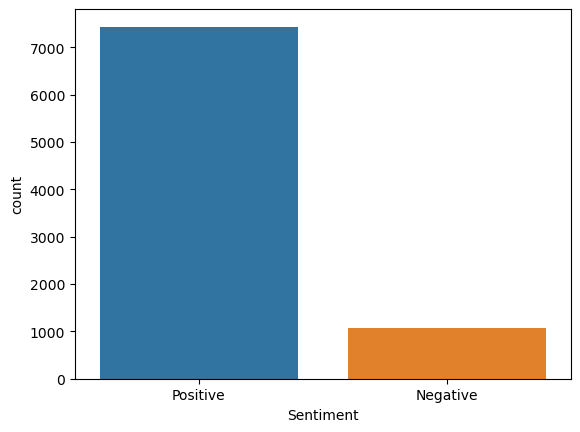

In [24]:
sns.countplot(x='Sentiment', data=df)

# Model Development

### Step 1 : Identifying Input and Output

In [25]:
y = df.Sentiment_num
X = df.Review
print(X.shape)
print(y.shape)

(8510,)
(8510,)


### Step 2 : Splitting data into train and test set

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6808,) (6808,)
(1702,) (1702,)


### Step 3 : Data Preprocessing on train data (X_train)

In [27]:
from wordcloud import WordCloud

def display_wordcloud(data):
    wc = WordCloud(background_color='black',
               width=1600,
               height=800).generate(' '.join(data))
    plt.figure(1,figsize=(30,20))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

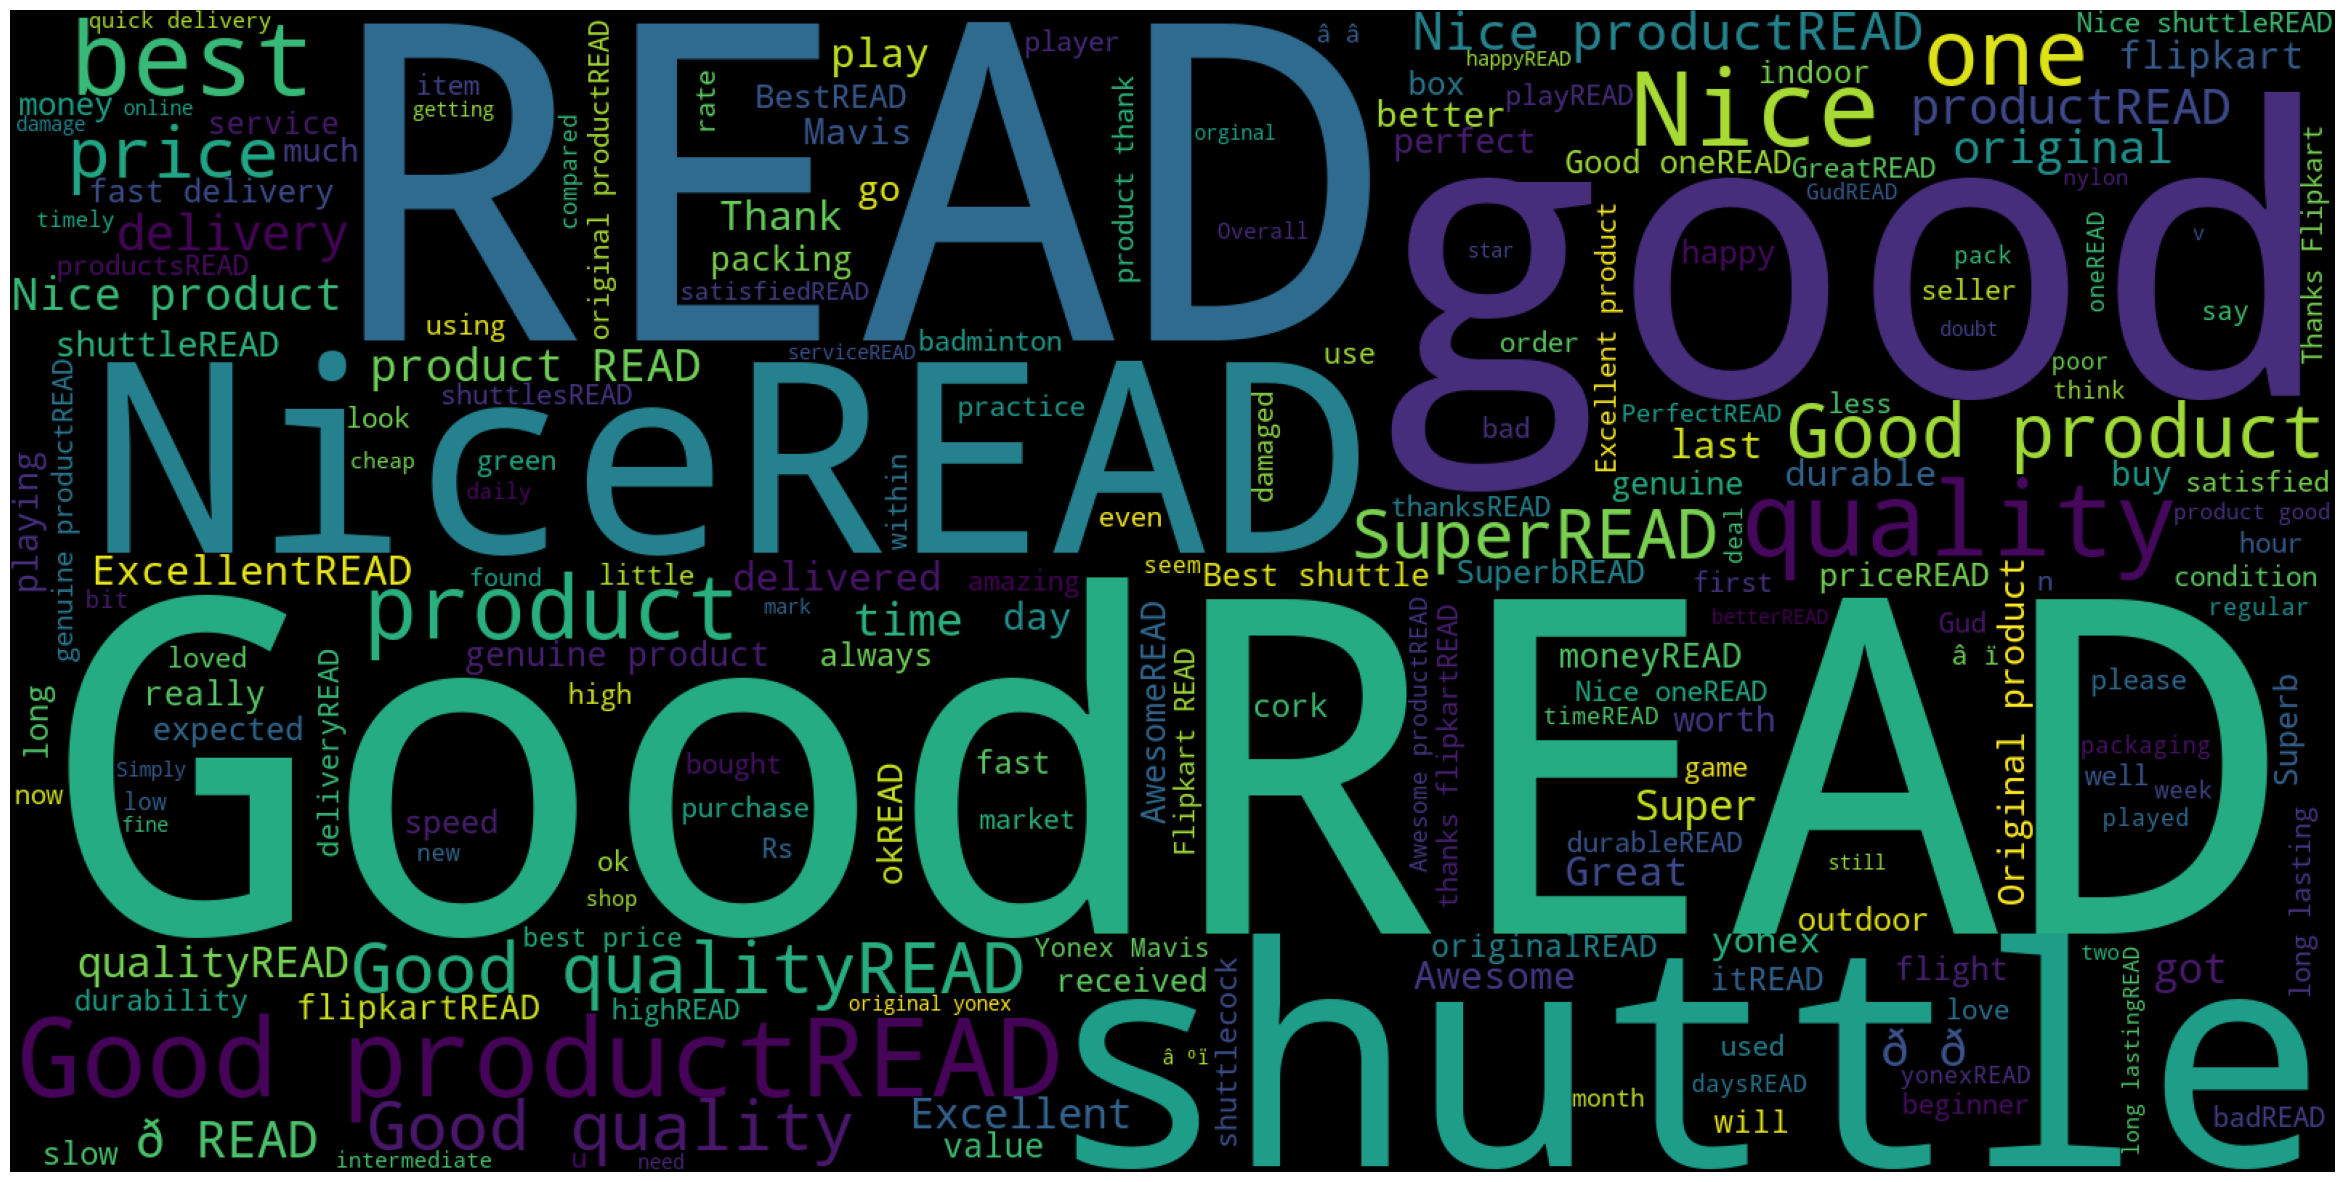

In [28]:
display_wordcloud(X_train[y_train==1])

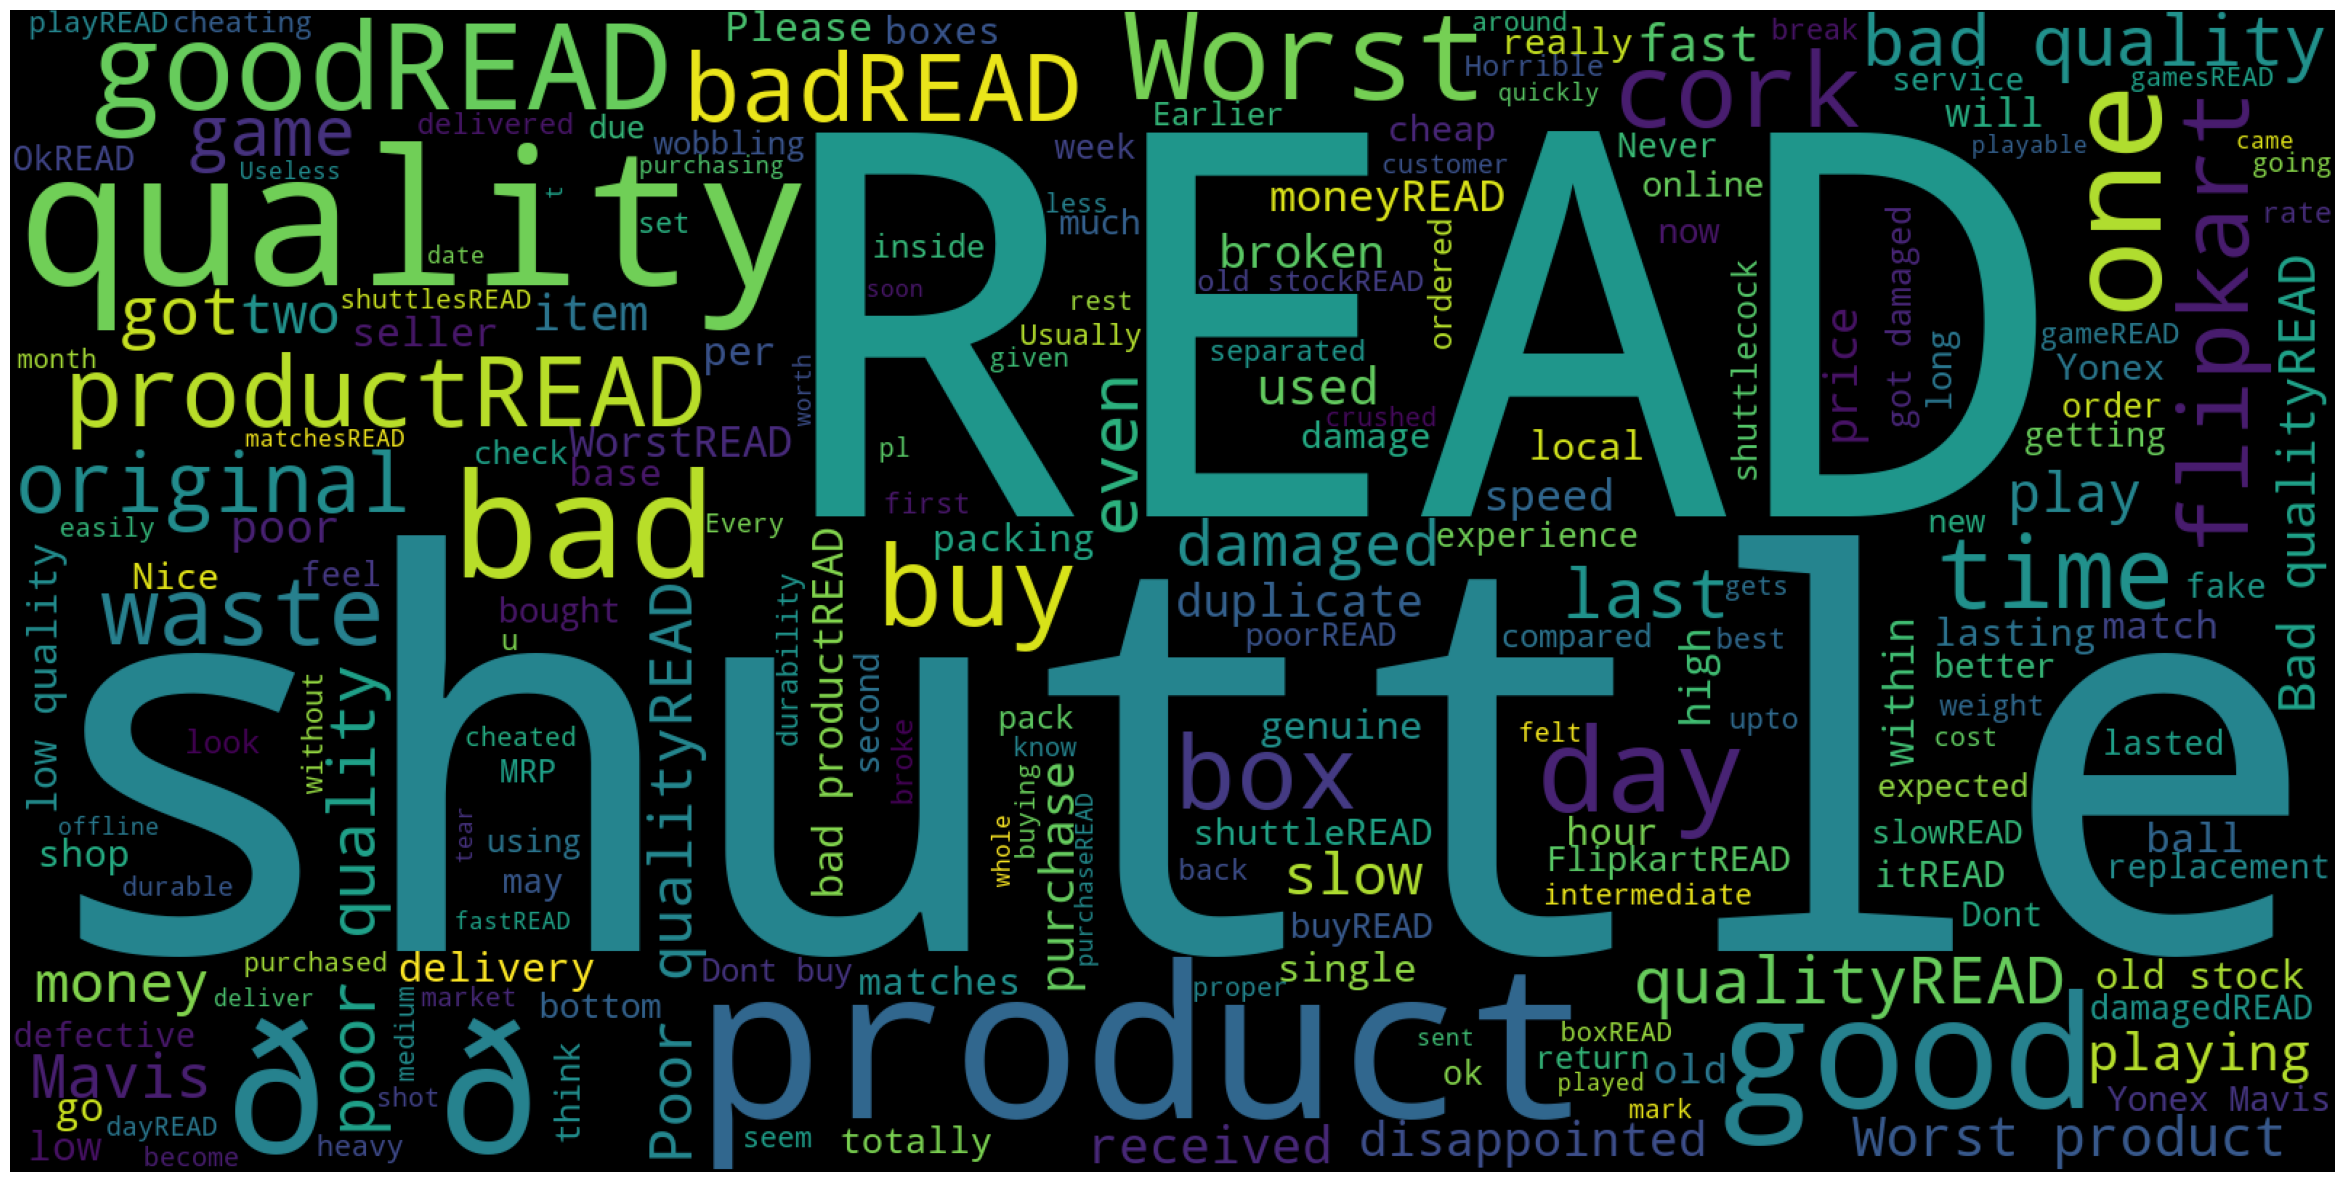

In [29]:
display_wordcloud(X_train[y_train==0])

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to C:\Users\Sarthak
[nltk_data]     Agrawal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
# Initialize WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
def preprocess_data(data): # data is a string of text
    # This text contains a lot of READ MORE
    data = data.replace("READ MORE", " ")
    
    # Remove punctuation and numbers.
    data = "".join([char for char in data if char not in string.punctuation and not char.isdigit()])

    # Converting to lower case
    data = data.lower()
    
    # Tokenization
    tokens = nltk.word_tokenize(data)

    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stop word removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
    # Join and return
    return " ".join(filtered_tokens)

In [33]:
# instantiate a vectorizer
vect = CountVectorizer(preprocessor=preprocess_data)

# use it to extract features from training data
%time X_train_dtm = vect.fit_transform(X_train)

print(X_train_dtm.shape)

CPU times: total: 2.66 s
Wall time: 3.63 s
(6808, 2609)


### Step 4 : Data Preprocessing on test data (X_test)

In [34]:
# transforming testing data (using training data's features)
X_test_dtm = vect.transform(X_test)

print(X_test_dtm.shape)

(1702, 2609)


### Step 5 : Building a Model (i.e. Train the classifier)

In [35]:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")

CPU times: total: 0 ns
Wall time: 3 ms


MultinomialNB()

### Step 6 : Evaluating on Train Data

In [36]:
# make class predictions for X_train_dtm
y_train_pred = nb.predict(X_train_dtm)

metrics.accuracy_score(y_train, y_train_pred)

0.9337544065804936

In [37]:
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 556,  314],
       [ 137, 5801]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

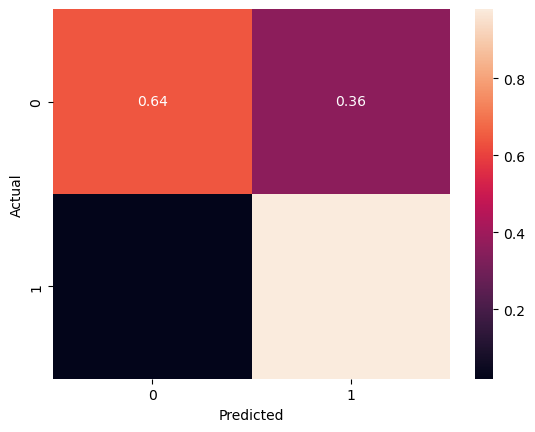

In [38]:
cm = metrics.confusion_matrix(y_train, y_train_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Step 7 : Evaluating on Test Data

In [39]:
# make class predictions for X_test_dtm
y_test_pred = nb.predict(X_test_dtm)

metrics.accuracy_score(y_test, y_test_pred)

0.9165687426556992

Text(0.5, 23.52222222222222, 'Predicted')

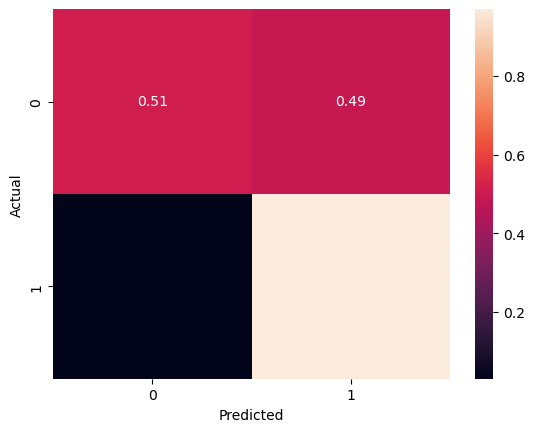

In [40]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [41]:
# # The accuracy is influenced due to the presence of data imbalance
# # Let's change the metric to F1 Score

print("Train Score (F1 Score):", metrics.f1_score(y_train, y_train_pred))

print("Test Score (F1 Score):", metrics.f1_score(y_test, y_test_pred))

Train Score (F1 Score): 0.9625819298100058
Test Score (F1 Score): 0.9535340314136126


At this point, we can notice that the classifier is doing poorly with identifying negative reviews, while it is doing extremely well with identifying positive reviews.

### Step 8 : Creating Pipelines for optimized workflow

In [42]:
%time X_train_clean = X_train.apply(lambda doc: preprocess_data(doc))

CPU times: total: 1.47 s
Wall time: 2.2 s


In [43]:
%time X_test_clean = X_test.apply(lambda doc: preprocess_data(doc))

CPU times: total: 328 ms
Wall time: 558 ms


In [44]:
# Define a memory object to cache intermediate results
cachedir = '.cache'
memory = Memory(location=cachedir, verbose=0)

pipelines = {
    'naive_bayes': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', MultinomialNB())
    ], memory=memory),
    'decision_tree': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', DecisionTreeClassifier())
    ], memory=memory),
    'logistic_regression': Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', LogisticRegression())
    ], memory=memory),
    'knn' : Pipeline([
        ('vectorization', CountVectorizer()),
        ('classifier', KNeighborsClassifier())
    ], memory=memory)
}

# Define parameter grid for each algorithm
param_grids = {
    'naive_bayes': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__alpha' : [1, 10]
        }
    ],
    'decision_tree': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__max_depth': [None, 5, 10]
        }
    ],
    'logistic_regression': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000], 
            'classifier__C': [0.1, 1, 10], 
            'classifier__penalty': ['elasticnet'], 
            'classifier__l1_ratio': [0.4, 0.5, 0.6],
            'classifier__solver': ['saga'],
            'classifier__class_weight': ['balanced']
        }
    ],
    'knn': [
        {
            'vectorization': [CountVectorizer(), TfidfVectorizer()],
            'vectorization__max_features' : [1000, 1500, 2000, 5000],
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__p' : [1, 2, 3]
        }
    ]
}

# Perform GridSearchCV for each algorithm
best_models = {}

for algo in pipelines.keys():
    print("*"*10, algo, "*"*10)
    grid_search = GridSearchCV(estimator=pipelines[algo], 
                               param_grid=param_grids[algo], 
                               cv=5, 
                               scoring='f1', 
                               return_train_score=True,
                               verbose=1
                              )
    
    %time grid_search.fit(X_train_clean, y_train)
    
    best_models[algo] = grid_search.best_estimator_
    
    print('Score on Test Data: ', grid_search.score(X_test_clean, y_test))

********** naive_bayes **********
Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: total: 8.17 s
Wall time: 13.4 s
Score on Test Data:  0.9536031589338598
********** decision_tree **********
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: total: 12.9 s
Wall time: 18.4 s
Score on Test Data:  0.9530592424732923
********** logistic_regression **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 3min 35s
Wall time: 5min 9s
Score on Test Data:  0.939816388983339
********** knn **********
Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 12min 43s
Wall time: 2min 59s
Score on Test Data:  0.9498868412544454


In [45]:
for name, model in best_models.items():
    print(f"{name}")
    print(f"{model}")
    print()

naive_bayes
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=1500)),
                ('classifier', MultinomialNB(alpha=1))])

decision_tree
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', TfidfVectorizer(max_features=5000)),
                ('classifier', DecisionTreeClassifier(max_depth=5))])

logistic_regression
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier',
                 LogisticRegression(C=10, class_weight='balanced', l1_ratio=0.6,
                                    penalty='elasticnet', solver='saga'))])

knn
Pipeline(memory=Memory(location=.cache\joblib),
         steps=[('vectorization', CountVectorizer(max_features=5000)),
                ('classifier', KNeighborsClassifier(n_neighbors=7, p=1))])



********** naive_bayes **********
CPU times: total: 0 ns
Wall time: 8 ms
Test Score (F1) 0.9536031589338598


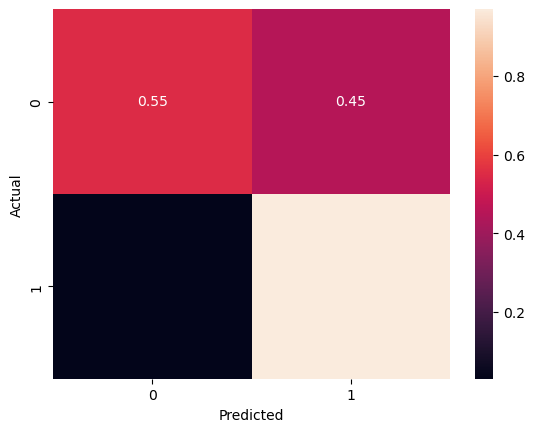

Model Size: 107398 Bytes
********** decision_tree **********
CPU times: total: 0 ns
Wall time: 9 ms
Test Score (F1) 0.9530592424732923


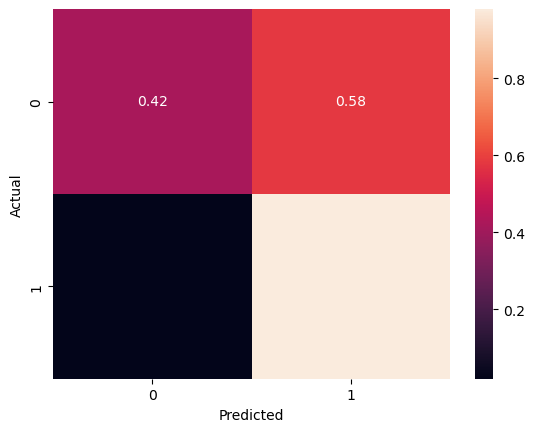

Model Size: 112204 Bytes
********** logistic_regression **********
CPU times: total: 15.6 ms
Wall time: 8 ms
Test Score (F1) 0.939816388983339


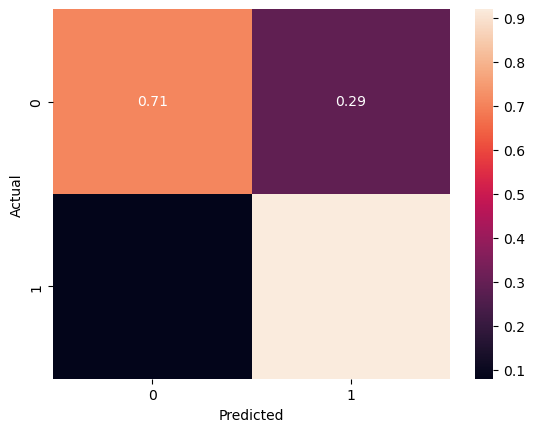

Model Size: 87961 Bytes
********** knn **********
CPU times: total: 1.38 s
Wall time: 221 ms
Test Score (F1) 0.9498868412544454


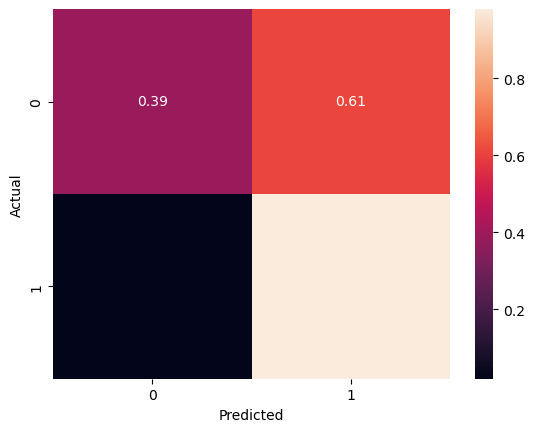

Model Size: 390763 Bytes


In [46]:
for name, model in best_models.items():
    print("*"*10, name, "*"*10)
    
    joblib.dump(model, f'best_models/{name}.pkl')
    model = joblib.load(f'best_models/{name}.pkl')
    
    %time y_test_pred = model.predict(X_test_clean)
    print("Test Score (F1)", metrics.f1_score(y_test, y_test_pred))
    
    cm = metrics.confusion_matrix(y_test, y_test_pred)
    actual = np.sum(cm, axis=1).reshape(-1, 1)
    cmn = np.round(cm/actual, 2)

    sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print("Model Size:", os.path.getsize(f'best_models/{name}.pkl'), "Bytes")

In [47]:
model = joblib.load('best_models/logistic_regression.pkl')
review_data = ["""I purchased an induction cooker with high hopes for a convenient and efficient cooking experience, but unfortunately, my experience has been far from satisfactory. Within just four months of regular use, the appliance abruptly stopped working, leaving me frustrated and disappointed.

Despite my initial excitement about the induction cooker's features, the abrupt failure was a major letdown. I promptly registered a complaint, hoping for a swift resolution to the issue. However, to my dismay, I have received no response from the company or any customer service representative.

The lack of communication and assistance in addressing the problem has left me feeling abandoned as a customer. It's disheartening to invest in a product only to have it malfunction so quickly, and the absence of support from the company has only added to the frustration.

In addition to the inconvenience caused by the sudden breakdown, the lack of responsiveness from customer service reflects poorly on the company's commitment to customer satisfaction. A reliable and responsive support system is crucial, especially when customers encounter issues with their purchases.

In conclusion, while the induction cooker initially showed promise, its short lifespan and the lack of customer support have left me regretting my purchase. I would caution potential buyers to thoroughly research a product's durability and the company's customer service reputation before making a similar investment
"""]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("Negative")

Negative


In [48]:
''' Due to lack of negative review data, the model is not trained well and suffers from 
    making accurate predictions on negative reviews. Here is an example :
 '''
model = joblib.load('best_models/logistic_regression.pkl')
review_data = ["The product was not upto the mark."]
prediction = model.predict(review_data)

if prediction == 1:
    print("Positive")
else:
    print("negative")

Positive
